In [11]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

import numpyro
from numpyro.contrib.einstein import Stein, kernels
from numpyro.contrib.callbacks import Progbar
from numpyro.distributions import NormalMixture, MultivariateNormal
from numpyro.infer import Trace_ELBO
from numpyro.infer.autoguide import AutoDelta
from numpyro.infer.initialization import init_with_noise, init_to_value
import warnings

In this tutorial we will explore the kernels available in EinStein with a couple of simple target distributions.
The goal is to
  - introduce the role of kernels in EinStein;
  - introduce the kernels in EinStein; and
  - build intuition about how the kernels behave.

The tutorial is outlined as
1. [EinStein and Kernels](#EinStein-and-Kernels)
2. [Target distributions](#Target-Distributions)
3. [Norm Kernels](#Scalar-Kernels)
    - [IMQ Kernel](#IMQ-Kerenl)
    - [Linear Kernel](#Linear-Kerenl)
    - [RBF Kernel](#RBF-Kerenl)
    - [Random Feature Kernel](#Random-Feature-Kerenl)
    - [Mixture Kernel](#Mixture-Kerenl)
4. [Vector Kernels](#Vector-Kernels)
    - [IMQ Vector Kernel](#IMQ-Vector-Kernel)
    - [RBF Vector Kernel](#RBF-Vector-Kernel)
5. [Matrix Kernels](#Matrix-Kernels)
  - [Graphical Kernel](#Graphical-Kernel)
  - [RBF Kernel](#RBF-Matrix-Kernel)

For simplicity we will use Stein Variational Gradient Descent (SVGD) in this tutorial. In NumPyro this equivalent to using
EinStein with Delta priors (e.g. `EinStein(model,AutoDelta(model),...)`).

## EinStein and Kernels
_TLDR: Kernels are special kinds of binary function. EinStein iteratively minimizes the KL-divergence between the guide
and model in the direction specified by the kernel. So different kernels give different directions which produces
different inferred parameters._

Kernels play a central role in EinStein, so it is worth understanding them and their role in some detail.
Lets remind ourselves how SVGD works. Lets assume we have $n$ samples $x_1,...,x_n$ from a known continuous
distribution $Q$, and we want to move these so that they approximate samples from another distribution $P$. We will
call the samples $x_i$ particles. We need to specify what is meant by approximating and how we will move particles.
We will measure how well $Q$ approximates $P$ by the KL-divergence (i.e. $\text{KL}(Q||P)$). Recall if $P=Q$
then $\text{KL}(Q||P)=0$.

To move the particles we will use the mapping $x \mapsto x + \epsilon g(x)$ which for (well
chosen) function $g$ will give a new distribution Q'. Now we want to choose $g$ so that we get the largest decrease in
KL divergence (i.e. $\max_g \text{KL}(Q||P) - \text{KL}(Q'||P)$) which turns out to be equivalent to maximizing the
kernel Stein Discrepancy $\text{KSD}_k(Q) = \max_{g\in\mathcal{G}} \mathbb{E}[\mathcal{T}g(\mathcal{X})]$.
If we choose $\mathcal{G}$ to be the unit ball of the reproducing Kernel Hilbert Space with kernel $k$,
then $\text{KSD}_k(Q)$ has a closed form optimal solution given by
$\mathbb{E}_{X \sim Q} [\nabla_x \log p(X)k(X,\cdot) + \nabla_xk(X,\cdot)]$. Choosing $Q$ to be the
empirical distribution $Q_n = n^{-1} \sum_{i=1}^n \delta_i$ we obtain the SVGD update rule
$x_i \leftarrow x_i + \epsilon \frac{1}{n}\sum_{j=1}^n (\nabla_{x_j} \log p(x_j)k(x_j,x_i) + \nabla_{x_j}k(x_j,x_i))$.

## Target Distributions

We will consider one- and two-dimensional target distributions. For the one dimensional distribution we will use a
mixture of two normal distributions and for two-dimensional target we will use a multivariate normal.

/tmp/ipykernel_11155/1831559283.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


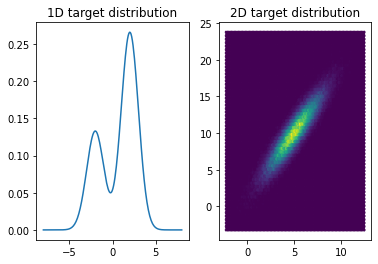

In [6]:
rng_key = jax.random.PRNGKey(42)
num_iterations = 6000

target_1d = NormalMixture(jnp.array([1 / 3, 2 / 3]),
                          jnp.array([-2., 2.]), jnp.array([1., 1.]))

target_2d_dist = MultivariateNormal(loc=jnp.array([5., 10.]), covariance_matrix=[[3., 5.], [5., 10.]])

fig, axs = plt.subplots(1, 2)

target_1d.sample(rng_key, (10_000,))

x = jnp.linspace(-8, 8., 200)
axs[0].plot(x, jnp.exp(target_1d.log_prob(x)), label='target_dist')
axs[0].set_title('1D target distribution')

axs[1].hexbin(*target_2d_dist.sample(rng_key, (100_000,)).T)
axs[1].set_title('2D target distribution')
fig.show()



## Norm Kernels
Normed kernels are kernels of the form $\mathbb{R]^d \rightarrow \mathbb{R}$. We will use $<x,x'>$ to denote the inner
product.

### IMQ Kernel
The Inverse Multi Quadratic (IMQ) kernel is given by $k(x,x') = \left(c^2 + |\!|x-x'|\!|^2_2\right)^\beta$. It is known
that we must $-1<\beta<0$ and $c>0$ for KSD to converge. With our current understanding of SVGD
__this is the recommended kernel to use__!

### Linear Kernel
The Linear kernel is given by $k(x,x') = <x,x'> + 1$. The fix point of SVGD will exactly match the first (mean) and
second (variance) moment of a multivariate Gaussian when using the linear kernel. This is a property that does not hold
for the Gaussian Radial-Basis-Function (RBF) kernel.

### RBF Kernel
The Gaussian Radial-Basis-Function (RBF) kernel is given by $k(x,x')=\exp\left(-1/h|\!|x-x'|\!|_2^2\right)$. $h$ is
the bandwidth, when $h \rightarrow 0$ the repulsive force of Stein force will vanish cause particles to collapse to a
single mode.

### Random Feature Kernel
The random feature kernel use a random subset of features to compute the kernel. The advantage over a universal kernels
$k'$ is that with $n$ particles at most $n$ function basis of $k'$ can be used, even if $k'(x,x')$ has infinite rank.

### Mixture Kernel
The mixture kernel is the weight average of n kernels $k_0,...,k_n$. The only restriction is that kernels $k_i$ be of
same type (i.e. norm, vector or matrix). So the mixture kernel is strictly speaking not just a norm kernel. However, the
notion (and usage) trivially extends from a mixture of norm kernels, so we will stick with these in this tutorial.

In [9]:
kernels_fns = {'rbf_kernel': kernels.RBFKernel(),
               'linear_kernel': kernels.LinearKernel(),
               'random_kernel': kernels.RandomFeatureKernel(),
               'imq_kernel': kernels.IMQKernel(),
               'matrix_kernel': kernels.MixtureKernel([0.5, 0.5],
                                                      [kernels.LinearKernel(),
                                                       kernels.RandomFeatureKernel()])}


def model():
    numpyro.sample('x', target_1d)

Rbf_Kernel:

Stein 1.9944: 100%|██████████| 6000/6000 [00:26<00:00, 229.40it/s]


Linear_Kernel:

Stein 2.1842: 100%|██████████| 6000/6000 [00:01<00:00, 4062.61it/s]


Random_Kernel:

Stein 2.0271: 100%|██████████| 6000/6000 [01:44<00:00, 57.53it/s]


Imq_Kernel:

Stein 1.9946: 100%|██████████| 6000/6000 [00:02<00:00, 2132.42it/s]


Matrix_Kernel:

Stein 2.0211: 100%|██████████| 6000/6000 [01:45<00:00, 56.91it/s]


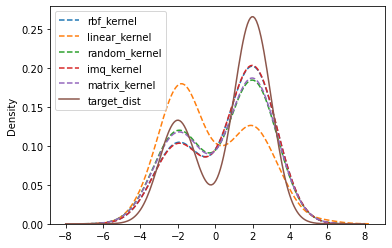

In [10]:
guide = AutoDelta(model)
init_strategy = init_with_noise(init_to_value(values={'x': -10.}), noise_scale=1.0)

for label, kernel_fn in kernels_fns.items():
    print(label.title(), end=':')
    svgd = Stein(model, guide, numpyro.optim.Adagrad(step_size=1.0), Trace_ELBO(),
                 kernel_fn, init_strategy=init_strategy, num_particles=100)
    state, _ = svgd.run(rng_key, num_iterations, callbacks=[Progbar()])
    sns.kdeplot(x=svgd.get_params(state)['x_auto_loc'], label=label, linestyle='dashed')

x = jnp.linspace(-8, 8., 200)
plt.plot(x, jnp.exp(target_1d.log_prob(x)), label='target_dist')
plt.legend()
plt.show()

In [ ]:
def model():
    numpyro.sample('x', target_2d_dist)


## Vector Kernels

## IMG Vector Kernel

### RBF Vector Kernel

In [ ]:
guide = AutoDelta(model)
svgd = Stein(model, guide, numpyro.optim.Adagrad(step_size=1.0), Trace_ELBO(),
             kernels.RBFKernel(mode='vector'),
             init_strategy=init_with_noise(init_to_value(values={'x': jnp.array([-10., 30.])}), noise_scale=1.0),
             num_particles=100)
svgd_state = svgd.init(rng_key)
init_loc = svgd.get_params(svgd_state)['x_auto_loc'].T

svgd_state, loss = svgd.run(rng_key, num_iterations, callbacks=[Progbar()])
rbf_kernel_loc = svgd.get_params(svgd_state)['x_auto_loc'].T

In [ ]:
guide = AutoDelta(model)
svgd = Stein(model, guide, numpyro.optim.Adagrad(step_size=1.0), Trace_ELBO(), kernels.GraphicalKernel(),
             init_strategy=init_with_noise(init_to_value(values={'x': jnp.array([-10., 30.])}), noise_scale=1.0),
             num_particles=100)
svgd_state = svgd.init(rng_key)
svgd_state, loss = svgd.run(rng_key, num_iterations, callbacks=[Progbar()])
graphical_kernel_loc = svgd.get_params(svgd_state)['x_auto_loc'].T

In [ ]:
fig, axs = plt.subplots(ncols=3)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sns.kdeplot(*init_loc, ax=axs[0])
    axs[0].set_title('Initial')
    sns.kdeplot(*rbf_kernel_loc, ax=axs[1])
    axs[1].scatter(*rbf_kernel_loc.mean(1).copy())
    axs[1].set_title('RBF Kernel')
    sns.kdeplot(*graphical_kernel_loc, ax=axs[2])
    axs[2].set_title('Graphical Kernel')

fig.show()

## Matrix Kernels

### Graphical Kernel

### RBF Matrix Kernel
